In [61]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from pymatgen.core.structure import IStructure, IMolecule
from pymatgen.io.vasp import Poscar
from pymatgen import Structure,Lattice
from lmfit import Parameters, minimize
from pymatgen.core.periodic_table import Element
from pymatgen.symmetry.kpath import KPathSeek
from pymatgen.io.vasp.inputs import Kpoints
import subprocess
from math import ceil

import topology_interface_main as tim #added line

In [64]:
def load_parameters(filename): 
    f = open(filename)
    parameters = Parameters()
    parameters.load(f)
    f.close() 
    return parameters



def get_kpoints_HSym(structure,line_density=20,coords_are_cartesian=False):
    kpath = KPathSeek(structure=structure)
    kpoints = kpath.get_kpoints(line_density=line_density, coords_are_cartesian=coords_are_cartesian)[0]
    kpoint_labels = kpath.get_kpoints(line_density=line_density, coords_are_cartesian=coords_are_cartesian)[1]
    return kpoints,kpoint_labels
   
    



def get_tot_valence_electron(structure):
    valence_el = 0
    
    for site in structure.sites:
        el =  Element(site.specie.symbol).electronic_structure
        valence_el+=np.sum([int(i[2:]) for i in el.split(".")[1:]])
    
    return valence_el

    


def Yaehmop_template(structure,kpoints=None,outfile="Yahemop_input",title="Element",**kwargs):
    
    '''
    additional printing option [distance matrix,overlap matrix,hamiltonian,wave func transp,
    charge mat transp,,energy levels]
    
    
    '''
    
    cords = [site.frac_coords.tolist() for site in structure.sites]
    lattice_edge_dummy_atoms = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
    species = [site.specie.symbol for site in structure.sites] 
    
    
    with open(outfile,"a") as file:
        file.write("{}\n".format(title))
        file.write("\n")
        file.write("; define the geometry, in crystallographic coordinates\n")
        file.write("Geometry Crystallographic\n")
        file.write("; this is the number of atoms\n")
        file.write("{}\n".format(len(cords)+len(lattice_edge_dummy_atoms)))
        file.write("; the * here indicates that custom parameters are being used.\n")
        
        count = 1
        
        for val in zip(species,cords):
            if count==1:
                file.write("{} * {}  {}  {}\n".format(count,val[1][0],val[1][1],val[1][2]))
                count+=1
            else:
                file.write("{} {} {}  {}  {}\n".format(count,val[0],val[1][0],val[1][1],val[1][2]))
                count+=1
             
        for site in lattice_edge_dummy_atoms:
            file.write("{} & {}  {}  {}\n".format(count,site[0],site[1],site[2]))
            count += 1
        file.write("\n")
        file.write("; define custom parameters\n")
        file.write("parameters\n")

        if 'parameters' in kwargs: 
            parameters = kwargs['parameters']
            param_list = [list(set(species))[0],
                          parameters['atomic_num'].value, 
                          parameters['num_val_ecectrons'].value,
                          parameters['principal_qn'].value, 
                          parameters['zeta_s'].value, 
                          parameters['IP_s'].value,
                          parameters['principal_qn'].value, 
                          parameters['zeta_p'].value, 
                          parameters['IP_p'].value]
        
        print(param_list)
        file.write("{}\n".format(" ".join([str(param) for param in param_list])))
        file.write("\n")
        file.write("The constant\n") 
        
        if "K" in kwargs:
            file.write("{}\n".format(kwargs["K"]))
        else:
            file.write("1.75\n")
        
        file.write("\n")    
        file.write("; definition of the lattice\n")
        file.write("lattice\n")
        file.write("; dimensionality\n")
        file.write("3\n")
        file.write("; number of overlaps in each direction\n")
        
        if 'separation' in kwargs:
            file.write("{} {} {}\n".format(ceil(kwargs['separation']/structure.lattice.a),
                                          ceil(kwargs['separation']/structure.lattice.b),
                                          ceil(kwargs['separation']/structure.lattice.c)))
        else:
            file.write("{} {} {}\n".format(ceil(20/structure.lattice.a),
                                          ceil(20/structure.lattice.b),
                                          ceil(20/structure.lattice.c)))
        file.write("{} {}\n".format(count-4,count-3))
        file.write("{} {}\n".format(count-4,count-2))
        file.write("{} {}\n".format(count-4,count-1))
        file.write("\n")
        
        file.write("Crystal Spec\n")
        file.write("{} {} {}\n".format(structure.lattice.a,structure.lattice.b,structure.lattice.c))
        file.write("{} {} {}\n".format(structure.lattice.alpha,structure.lattice.beta,structure.lattice.gamma))
        
        file.write("\n")
        
        if "print" in kwargs:
            file.write("print\n")
            for pr in kwargs["print"]:
                file.write("{}\n".format(pr))
            file.write("end_print\n")
            
        file.write("\n")
        
        if kpoints is None:
            file.write("k points\n")
            kpts,kpts_labels = get_kpoints_HSym(structure)
            file.write("{}\n".format(len(kpts)))
            for kpt in kpts:
                file.write("{}\n".format(" ".join([str(i) for i in kpt])))
        else:
            file.write("k points\n")
            file.write("{}\n".format(len(kpoints)))
            for kpt in kpoints:
                file.write("{}\n".format(" ".join([str(i) for i in kpt])))
                
        file.write("\n")
        file.write("average properties\n")
        file.write("\n")
        
        file.write("electrons\n")
        file.write("{}\n".format(get_tot_valence_electron(structure)))
        
        
    
def run_Yaehmop_calculation(infile,workdir):
    baseDir = os.getcwd()
    os.chdir(workdir)
    subprocess.run(['bind','{}'.format(infile)])
    os.chdir(baseDir)
        
                
        
         




In [86]:
from shutil import rmtree

rmtree("{}/calc".format(os.getcwd()))
os.mkdir("calc")

struct = Poscar.from_file("POSCAR").structure
params = load_parameters("final_params.txt")

surfaces="default" #added line
n=10 #added line
kpoints=tim.generate_k_3D(n=10,surfaces=surfaces) #added line
kpoints_hsym=get_kpoints_HSym(struct) #added line
kpoints=vstack((kpoints,kpoints_hsym)) #added line
outfile="calc/Si"

Yaehmop_template(struct,outfile= outfile,kpoints=kpoints, parameters=params,
                 print=["energy levels",'overlap matrix','hamiltonian'])

run_Yaehmop_calculation("Si","{}/calc".format(os.getcwd()))






['Si', 14, 4, 3, 1.8589061743709645, -19.968739072723935, 3, 1.6220370154097585, -14.099137968945543]


In [87]:
from utilis import *
from Bands import Band

Text(0, 0.5, 'E-E$_{fermi}$ (eV)')

/global/homes/s/sbanik/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


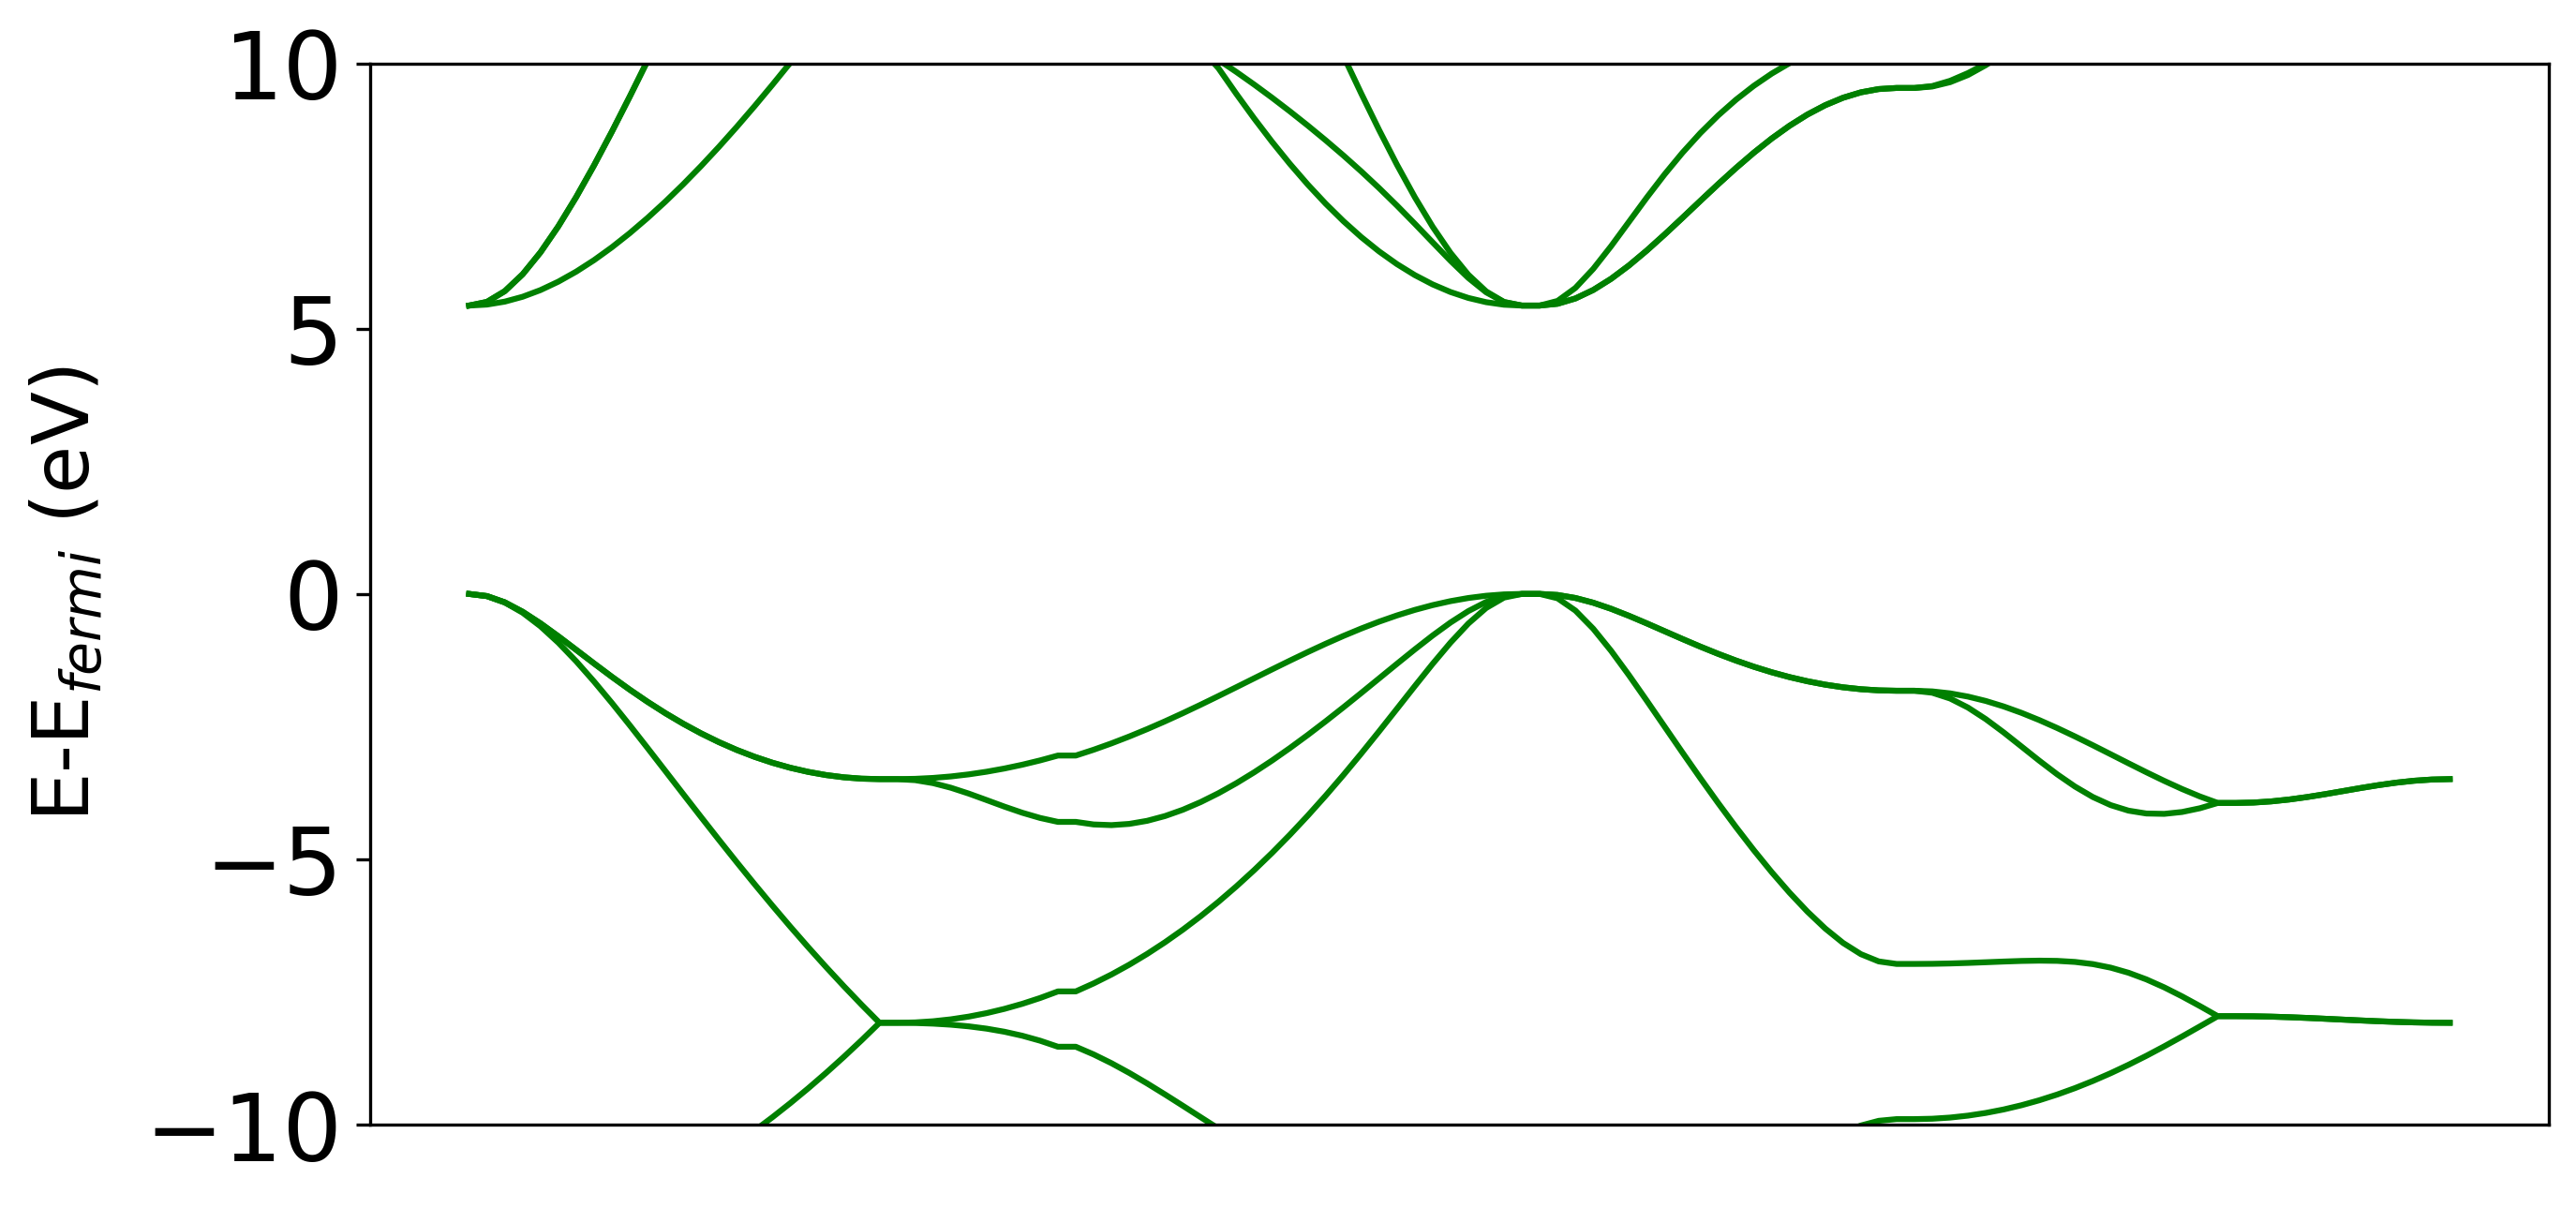

In [88]:
bandDict = _parse_eigenvalues("calc/Si.out")

band = Band(bandDict)
typeDict = band.get_cbm_vbm()

    
fig = plt.figure(constrained_layout=True,figsize = (10,5),dpi = 300)
gs = GridSpec(1, 1, height_ratios=[1])
ax = fig.add_subplot(gs[0])
for band in bandDict['bands']- bandDict['efermi']:
    ax.plot(band,color='g')
        
ax.set_ylim([-10,10])
ax.set_xticks([])
ax.set_ylabel("E-E$_{fermi}$ (eV)",size =20,labelpad=10)


# Get topological invariants from Yaehmop calculation

In [ ]:
#outfile, n and surface are defined above when generating kpoints
c,z=tim.get_topology(outfile,ham_type="eigval",surfaces=surfaces,n=n)
print(z)